In [30]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
tf.random.set_seed(1234)

warnings.filterwarnings('ignore')

import os
def load_data():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if filename.endswith('.csv'):
                data = pd.read_csv(os.path.join(dirname, filename))
                return data

In [32]:
data = load_data()

In [33]:
data.head()

,Date,Open,High,Low,Close
0,01/17/2025,1.0301,1.0332,1.0263,1.0276
1,01/16/2025,1.0290,1.0318,1.0263,1.0303
2,01/15/2025,1.0310,1.0353,1.0261,1.0292
3,01/14/2025,1.0243,1.0311,1.0239,1.0309
4,01/13/2025,1.0258,1.0258,1.0179,1.0246


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Step 2: Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))
# print(data_scaled)
print("Jumlah data tersedia:", len(data_scaled))
data_scaled = data_scaled.reshape(-1, 1)


Jumlah data tersedia: 263


In [35]:
# Fungsi untuk membuat dataset dengan window
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

In [36]:
# Membuat dataset
time_step = 60
X, Y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data training dan testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [39]:
# Simpan data training dan testing ke file pkl
with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, Y_train, Y_test), f)

In [40]:
# Step 3: Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step,1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.3484 - val_loss: 0.0142
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0537 - val_loss: 0.0062
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0216 - val_loss: 0.0152
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0244 - val_loss: 0.0042
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0183 - val_loss: 0.0041
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0144 - val_loss: 0.0045
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0165 - val_loss: 0.0059
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0161 - val_loss: 0.0069
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0164 - val_loss: 0.0039
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0167 - val_loss: 0.0041
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0142 - val_loss: 0.0052


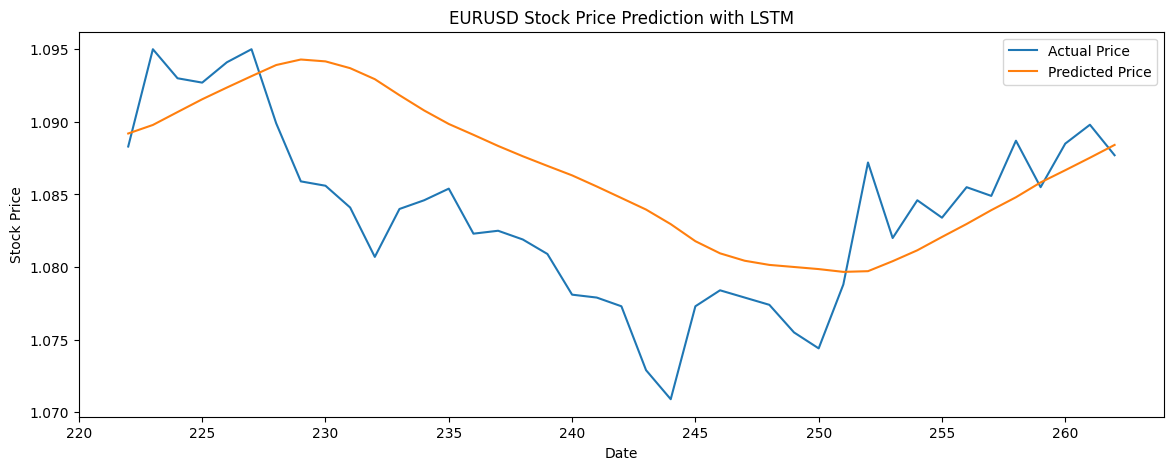

In [41]:
# Step 4: Train Model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Step 5: Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))  # Ubah prediksi ke skala asli

# Step 6: Visualization
plt.figure(figsize=(14,5))
plt.plot(data.index[-len(Y_test):], scaler.inverse_transform(Y_test.reshape(-1,1)), label='Actual Price')
plt.plot(data.index[-len(Y_test):], predictions, label='Predicted Price')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'EURUSD Stock Price Prediction with LSTM')
plt.show()
